In [1]:
#@Imports
import sys
import os
path = os.path.abspath('.')
if path not in sys.path:
  sys.path.insert(0, path)

%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from retry import retry

from ollama_model import OllamaLanguageModel

In [2]:
system_message = ("This is an agent based model. "
  f"The goal of the LLM to to play characters in a game, and act as humanlike as possible. "
  "Ideally, human observers should not be able to tell the difference between the LLM and a human player. "
)

model = OllamaLanguageModel(
"llama3", system_message=system_message, streaming=False
)

@retry(ValueError, tries=5)
def compute_desire_for_gamble(model, object):
  """compute value."""
  request = (
      f"You are very logical and rational when doing this task"
      f"You are presented with a gamble. it has a probability of winning, a value of winning, and a value of losing. "
      f"If you win, you get the win value, if you lose, you get loss value. "
      f"The probability of winning is the 'win_probability']. "
      f"You need to think about an option, and how desirable it is. "
      f"Compute the expected value of the gamble first. "
      f"Think about how good or bad it is and provide a affective feeling preference value between -1 and 1 "
      f"which corresponds to the desirability of the option. "
      f"Use -1 for very bad, 0 for neutral, and 1 for very good. "
      f"The option is: {object}"
      f"Provide this answer in the form of a number between -1 and 1. "
      f"Provide only a single number as the response."
      f"Do not provide any explanations, just provide a single number."
  )

  output = model.sample_text(
    request
  )
  return float(output)

In [3]:
expected_values = []
attitudes = []
for i in range(500):
  # Simulate decision making for each player.
  Good_value = np.random.choice(np.arange(10))
  Bad_value = np.random.choice(np.arange(10))
  P_w = np.random.choice(np.arange(10) / 10)

  # Compute the expected value of the gamble.
  expected_value = P_w * Good_value + (1 - P_w) * -1*Bad_value
  gamble_input = f"Probability of Winning (P_w): {P_w}, Positive Value on Win (G): {Good_value}, Negative Value on Loss (B): {-Bad_value}"
  # Compute affective LLM value estimate
  llm_value = compute_desire_for_gamble(model, gamble_input)
  expected_values.append(expected_value)
  attitudes.append(llm_value)

  # Print trial outputs
  clear_output(wait = True)
  print(f"===========")
  print(f"Trial {i+1}:")
  print(f"EV:    {round(expected_value, 2)}")
  print(f"Value: {round(llm_value, 2)}")
  print(f"===========")
clear_output(wait = True) 

Trial 500:
EV:    -1.0
Value: -0.33


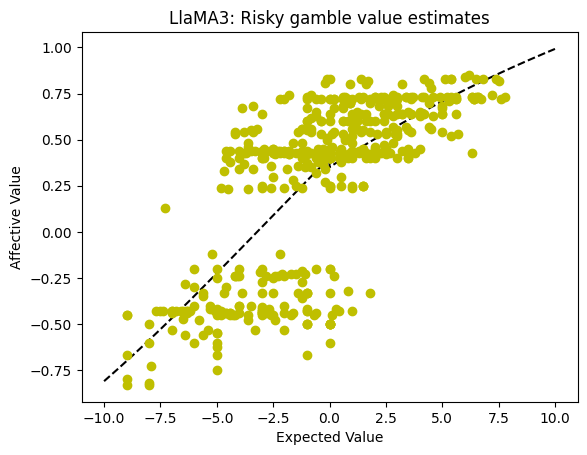

In [7]:
%autoreload 2
from prospect_theory import curve_fit, plot_curve

outcomes = curve_fit(expected_values, attitudes)
plot_curve(*outcomes, expected_values, attitudes, title = "LlaMA3: Risky gamble value estimates")